In [9]:
# 1.图像增广
%matplotlib inline
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

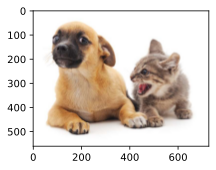

In [10]:
d2l.set_figsize()
img = d2l.Image.open('catdog.jpg')
d2l.plt.imshow(img)

In [19]:
def apply(
    img, aug, num_rows=2, num_cols=4, scale=2):
    y = [aug(img) for _ in range(num_rows * num_cols)]
    d2l.show_images(y, num_rows, num_cols, scale=scale)

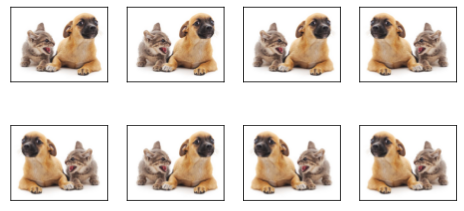

In [20]:
# 左右翻转
apply(img, torchvision.transforms.RandomHorizontalFlip())

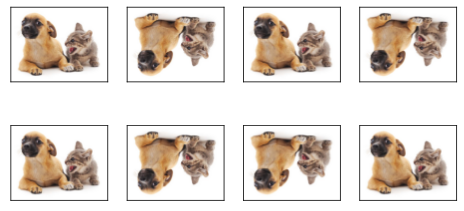

In [22]:
# 上下翻转
apply(img, torchvision.transforms.RandomVerticalFlip())

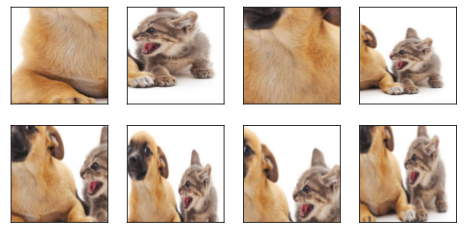

In [23]:
# 随机剪裁
shape_aug = torchvision.transforms.RandomResizedCrop(
    (200, 200), scale=(0.1, 1), ratio=(0.5, 2))
apply(img, shape_aug)

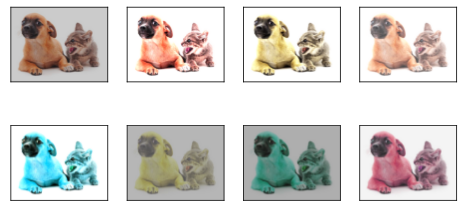

In [25]:
# 改变颜色
color_aug = torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0.5, 
    saturation=0.5, hue=0.5)
apply(img, color_aug)

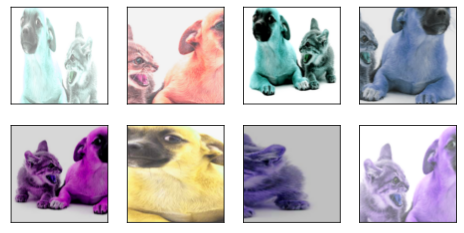

In [26]:
# 结合多种增广方法
augs = torchvision.transforms.Compose(
    [torchvision.transforms.RandomHorizontalFlip(), 
     color_aug, shape_aug])
apply(img, augs)

In [35]:
# 使用图像增广来训练
all_images = torchvision.datasets.CIFAR10(
    train=True, root='~', download=True)
all_images[0]

Files already downloaded and verified


(<PIL.Image.Image image mode=RGB size=32x32 at 0x2B3424EEDC0>, 6)

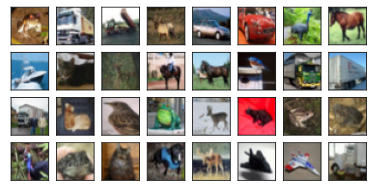

In [33]:
d2l.show_images(
    [all_images[i][0] for i in range(32)], 
    4, 8, scale=0.8)
d2l.plt.show()

In [38]:
train_augs = torchvision.transforms.Compose(
    [torchvision.transforms.RandomHorizontalFlip(), 
     torchvision.transforms.ToTensor()])
test_augs = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor()])

In [40]:
def load_cifar10(is_train, augs, batch_size):
    dataset = torchvision.datasets.CIFAR10(
        root='~', train=is_train)
    dataloader = torch.utils.data.DataLoader(
        datasets, batch_size=batch_size, 
        shuffle=is_train, num_workers=4)
    return dataloader

In [42]:
# 多 GPU 训练
#@save
def train_batch_ch13(net, x, y, loss, trainer, devices):
    if isinstance(x, list):
        x = [X.to(devices[0]) for X in x]
    else:
        x = x.to(devices[0])
    y = y.to(devices[0])
    net.train()
    trainer.zero_grad()
    pred = net(x)
    l = loss(pred, y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = d2l.accuracy(pred, y)
    return train_loss_sum, train_acc_sum

In [44]:
#@save
def train_ch3(
    net, train_iter, test_iter, loss, trainer, num_epochs, 
    devices=d2l.try_all_gpus()):
    timer, num_batches = d2l.Timer(), len(train_iter)
    animator = d2l.Animator(
        xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1], 
        legend=['train loss', 'train acc', 'test acc'])
    net = nn.DataParallel(
        net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(4)
        # 训练损失，训练精确度，实例数，特点数
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch_ch13(
                net, features, labels, loss, 
                trainer, devices)
            metric.add(l, acc, labels.shape[0], labels.numel())
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0\
                or i == num_batches - 1:
                animator.add(
                    epoch + (i + 1) / num_batches, 
                    (metric[0] / metric[2], 
                     metric[1] / metric[3], None))
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f"loss:{metric[0] / metric[2]:.3f}, train acc:{metric[1] / metric[3]:.3f}, test acc:{test_acc:.3f}")
    print(f"{metric[2] * num_epochs / timer.sum():.1f} examples/sec on{str(devices)}")

In [46]:
batch_size, devices, net = 256, d2l.try_all_gpus(), d2l.resnet18(10, 3)

In [51]:
def init_weights(m):
    if type(m) in [nn.Linear, nn.Conv2d]:
        nn.init.xavier_uniform_(m.weight)

In [52]:
net.apply(init_weights)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (resnet_block1): Sequential(
    (0): Residual(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Residual(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (resnet_block2): Sequential(
   

In [53]:
def train_with_data_aug(
    train_augs, test_augs, net, lr=0.001):
    train_iter = load_cifar10(True, train_augs, batch_size)
    test_iter = load_cifar10(False, test_augs, batch_size)
    loss = nn.CrossEntropyLoss(reduction='none')
    trainer = torch.optim.Adam(net.parameters(), lr=lr)
    train_ch13(net, train_iter, test_iter, loss, 
               trainer, 10, devices)

In [ ]:
# train_with_data_aug(train_augs, test_augs, net)
# LiMu 用了 4 个 GPU 训练了 4 min

In [2]:
# 2.微调
# 3.目标检测和边界框

In [1]:
# 4.锚框
import torch
ground_truth = torch.tensor([[0, 0.1, 0.08, 0.52, 0.92], 
                             [1, 0.55, 0.2, 0.9, 0.88]])
anchors = torch.tensor([[0, 0.1, 0.2, 0.3], 
                        [0.15, 0.2, 0.4, 0.4], 
                        [0.63, 0.05, 0.88, 0.98], 
                        [0.66, 0.45, 0.8, 0.8], 
                        [0.57, 0.3, 0.92, 0.9]])

In [9]:
anchors = anchors.unsqueeze(dim=0)
ground_truth = ground_truth.unsqueeze(dim=0)
ground_truth.size(), anchors.size()

(torch.Size([1, 2, 5]), torch.Size([1, 5, 4]))

In [10]:
ground_truth[:, 1:]

tensor([[[1.0000, 0.5500, 0.2000, 0.9000, 0.8800]]])

In [11]:
anchors.shape[0]

1

In [13]:
x = torch.randn(size=(1, 3, 561, 728))
in_height, in_width = x.shape[-2:]
steps_h, steps_w = 1.0 / in_height, 1.0 / in_width
in_height, in_width, steps_h, steps_w

(561, 728, 0.0017825311942959, 0.0013736263736263737)

In [16]:
offset_h, offset_w = 0.5, 0.5

In [19]:
center_h = (torch.arange(in_height) + offset_h) * steps_h
center_w = (torch.arange(in_width) + offset_w) * steps_w
center_h.size(), center_w.size()

(torch.Size([561]), torch.Size([728]))

In [22]:
shift_y, shift_x = torch.meshgrid(center_h, center_w)
shift_y.size(), shift_x.size()

(torch.Size([561, 728]), torch.Size([561, 728]))

In [31]:
a = torch.tensor([1, 2, 3])
b = torch.tensor([4, 5])
c = torch.tensor([4, 5, 6])
a.size(), b.size(), c.size()

(torch.Size([3]), torch.Size([2]), torch.Size([3]))

In [32]:
x, y = torch.meshgrid(a, c)
x, y, x.size(), y.size()

(tensor([[1, 1, 1],
         [2, 2, 2],
         [3, 3, 3]]),
 tensor([[4, 5, 6],
         [4, 5, 6],
         [4, 5, 6]]),
 torch.Size([3, 3]),
 torch.Size([3, 3]))

In [37]:
box_area = lambda boxes:(
    (boxes[:, 2] - boxes[:, 0]) * (
        boxes[:, 3] - boxes[:, 1]))

In [38]:
box_area(anchors.squeeze(0))

tensor([0.0400, 0.0500, 0.2325, 0.0490, 0.2100])

In [46]:
for i in range(1):
    label = ground_truth[i:, :, :]
    print(label)
    break

tensor([[[0.0000, 0.1000, 0.0800, 0.5200, 0.9200],
         [1.0000, 0.5500, 0.2000, 0.9000, 0.8800]]])


In [50]:
anchors.squeeze(0), anchors.squeeze(0)[:, None, :2]

(tensor([[0.0000, 0.1000, 0.2000, 0.3000],
         [0.1500, 0.2000, 0.4000, 0.4000],
         [0.6300, 0.0500, 0.8800, 0.9800],
         [0.6600, 0.4500, 0.8000, 0.8000],
         [0.5700, 0.3000, 0.9200, 0.9000]]),
 tensor([[[0.0000, 0.1000]],
 
         [[0.1500, 0.2000]],
 
         [[0.6300, 0.0500]],
 
         [[0.6600, 0.4500]],
 
         [[0.5700, 0.3000]]]))

In [52]:
torch.full((2, 3), -1)

tensor([[-1, -1, -1],
        [-1, -1, -1]])

In [3]:
# 9.语义分割和数据集
colormap2label = torch.zeros(256 * 3, dtype=torch.long)
colormap2label.size()

torch.Size([768])

In [5]:
voc_colormap = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0]]
voc_classes = ['background', 'aeroplane', 'bicycle', 'bord']

In [9]:
for i, colormap in enumerate(voc_colormap):
    print(colormap)

[0, 0, 0]
[128, 0, 0]
[0, 128, 0]
[128, 128, 0]
